In [1]:
!pip install ipywidgets

In [2]:
!pip install pyreadstat

  Obtaining dependency information for pyreadstat from https://files.pythonhosted.org/packages/82/cc/519ee6307f25e40a349cc1cef730b9b47bf7ef81a94f9b14afcc7d058374/pyreadstat-1.2.7-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 10.4 MB/s eta 0:00:0000:0100:01


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import seaborn as sns
import pyreadstat
from scipy import stats

import ipywidgets as widgets
from IPython.display import display

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
# set display full table
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 1. Load Data

In [6]:
datafile_loc = "P15644_20220301.sav"

In [7]:
ori_df, meta = pyreadstat.read_sav(datafile_loc, apply_value_formats=False)

In [8]:
ori_df.shape

(2777, 81)

In [9]:
ori_df.columns

Index(['panelid_2', 'Panel_PSU', 'Panel_Strata', 'Jun21_WeightBoost',
       'Jun21_IntDate', 'Jun21_IntMode', 'ff_disact', 'Cur_GOR',
       'cur_urbrurew', 'cur_urbrurs', 'Cur_Sex', 'Cur_RClassGp', 'Cur_AgeCat',
       'Cur_HEdQual', 'Cur_RelStat5', 'Cur_HHSize5', 'Cur_HHChild',
       'Cur_HHType', 'Cur_SubjInc', 'Cur_HHIncome4_21',
       'Cur_HHIncome4_21_Imputed', 'Cur_HHIncomeEquiv4_21',
       'Cur_HHIncomeEquiv4_21_Imputed', 'Cur_IdentClass', 'Cur_PartyID5',
       'Cur_Ethnic6', 'Cur_IntUse3', 'Tenure', 'MortCost', 'RentCost',
       'CvBedRoom', 'HomeProb01', 'HomeProb02', 'HomeProb03', 'HomeProb04',
       'HomeProb05', 'HomeProb06', 'HomeProb07', 'HomeProb08', 'HomeProb09',
       'HomeProb10', 'HomeProb11', 'HomeProb12', 'HomeProb13', 'HomeProb14',
       'HomeProb15', 'HomeProb16', 'HomeProb17', 'HomeProb_Oth',
       'NeighQual_CrimeSafety_q', 'NeighQual_TrafficSafety_q',
       'NeighQual_FoodStores_q', 'NeighQual_AccessPubTrans_q',
       'NeighQual_AccessSocCult_q', 

# 2. Data cleaning

### Housing Cost to Income

In [10]:
# 98 rows have both mortcost and rentcost as null 
ori_df['MortCost']  =ori_df['MortCost'].fillna(0)
ori_df['RentCost']  =ori_df['RentCost'].fillna(0)
ori_df['HousingCost'] =ori_df['MortCost'] +ori_df['RentCost'] # Monthly

In [11]:
new_mean_group = list(map(lambda x:((x[1]+x[0])/2), [[0,1410],[1410,2560],[2560, 4350]]))
print(new_mean_group)

[705.0, 1985.0, 3455.0]


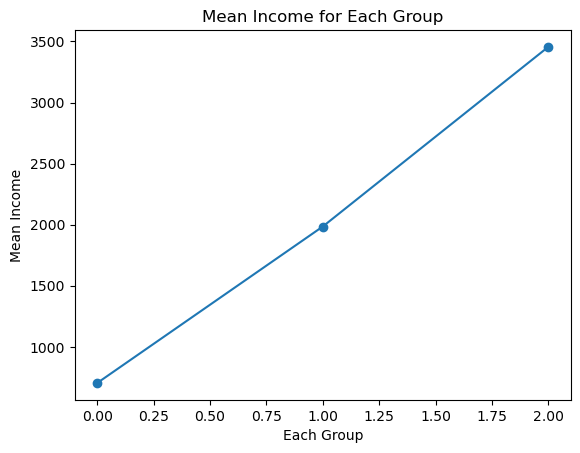

In [12]:
plt.plot([0,1,2], new_mean_group[:3], marker='o')
plt.xlabel('Each Group')
plt.ylabel('Mean Income')
plt.title('Mean Income for Each Group')
plt.show()

Estimated mean income for the highest open-ended interval (Group 3): £4925.00


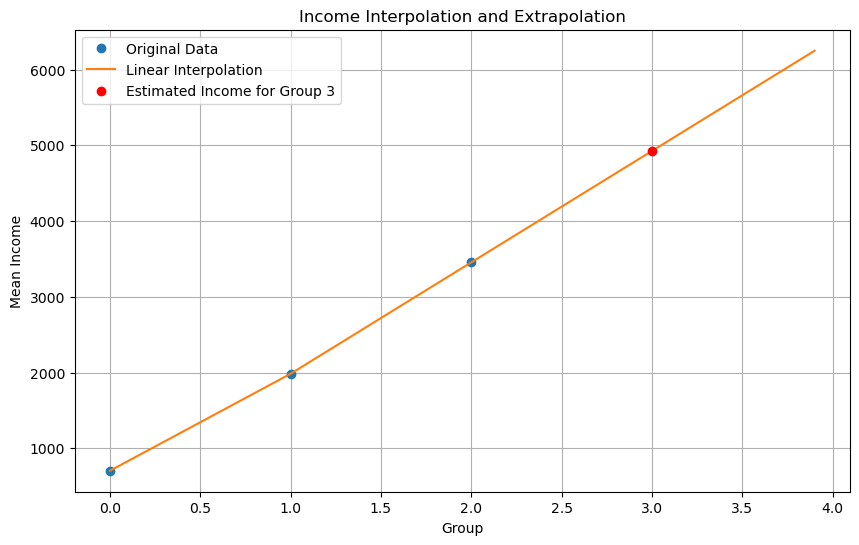

In [13]:
# Calculate linear interpolation
from scipy.interpolate import interp1d, CubicSpline

groups = np.array([0, 1, 2])
mean_incomes = np.array([705, 1985, 3455])

linear_interp = interp1d(groups, mean_incomes, kind='linear', fill_value='extrapolate')
new_group = 3
estimated_income = linear_interp(new_group)
print(f"Estimated mean income for the highest open-ended interval (Group {new_group}): £{estimated_income:.2f}")

# Plot the results
new_groups = np.arange(0, 4, 0.1)
linear_interp_values = linear_interp(new_groups)
plt.figure(figsize=(10, 6))
plt.plot(groups, mean_incomes, 'o', label='Original Data')
plt.plot(new_groups, linear_interp_values, '-', label='Linear Interpolation')
plt.scatter(new_group, estimated_income, color='red', zorder=5, label=f'Estimated Income for Group {new_group}')
plt.title('Income Interpolation and Extrapolation')
plt.xlabel('Group')
plt.ylabel('Mean Income')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
new_mean_group.append(4925.0)
print(new_mean_group)

[705.0, 1985.0, 3455.0, 4925.0]


In [15]:
print(ori_df['Cur_HHIncome4_21_Imputed'].isnull().sum())
ori_df = ori_df.dropna(subset=['HousingCost', 'Cur_HHIncome4_21_Imputed'])

118


In [16]:
def HousingCostToIncome(row):
    income_mean_group = [705.0, 1985.0, 3455.0, 4925.0]
    income = income_mean_group[int(row['Cur_HHIncome4_21_Imputed']) - 1]
    HousingCost = row['HousingCost']
    HousingCostToIncome = HousingCost / income
    return HousingCostToIncome

In [17]:
ori_df['HousingCostToIncome'] = ori_df.apply(HousingCostToIncome, axis=1)

### Home Problems

In [18]:
# define 'HomeProbTotal' as the sum of 'HomeProb01' to 'HomeProb14'
ori_df['HomeProbTotal'] = ori_df.loc[:, 'HomeProb01':'HomeProb14'].sum(axis=1)

### Neighbourhood Quality

In [19]:
# drop nan value (80 missing values)
ori_df = ori_df.dropna(subset=['NeighQual_CrimeSafety_q', 'NeighQual_TrafficSafety_q', 'NeighQual_FoodStores_q',
       'NeighQual_AccessPubTrans_q', 'NeighQual_AccessSocCult_q',
       'NeighQual_AccessRetail_q', 'NeighQual_AccessRec_q',
       'NeighQual_EaseWalk_q', 'NeighQual_EaseCycle_q',
       'NeighQual_OutdoorPlay_q', 'NeighQual_QualitySchools_q',
       'NeighQual_NeighbourSoc_q'])

print(ori_df.loc[:, 'NeighQual_CrimeSafety_q':'NeighQual_NeighbourSoc_q'].isnull().sum())

ori_df['NeighQualTotal'] = ori_df.loc[:, 'NeighQual_CrimeSafety_q':'NeighQual_NeighbourSoc_q'].sum(axis=1)

NeighQual_CrimeSafety_q       0
NeighQual_TrafficSafety_q     0
NeighQual_FoodStores_q        0
NeighQual_AccessPubTrans_q    0
NeighQual_AccessSocCult_q     0
NeighQual_AccessRetail_q      0
NeighQual_AccessRec_q         0
NeighQual_EaseWalk_q          0
NeighQual_EaseCycle_q         0
NeighQual_OutdoorPlay_q       0
NeighQual_QualitySchools_q    0
NeighQual_NeighbourSoc_q      0
dtype: int64


### Transport Time

In [20]:
ori_df[['CommuteTimePreCov', 'FoodTimePreCov', 'CommuteTime', 'FoodTime']].isnull().sum()

CommuteTimePreCov    1080
FoodTimePreCov        265
CommuteTime          1677
FoodTime              415
dtype: int64

### Distribution 

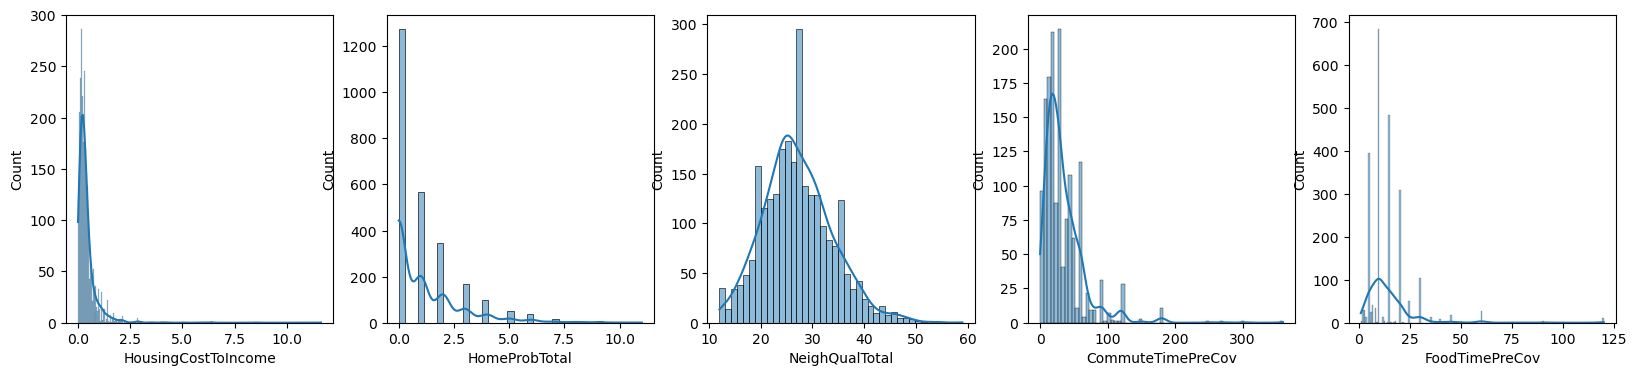

In [21]:
# plot for 'HousingCostToIncome'、'HomeProbTotal' 、 'NeighQualTotal' 、'TransportTime'
# plot in one figure 
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
sns.histplot(ori_df['HousingCostToIncome'], ax=axes[0], kde=True)
sns.histplot(ori_df['HomeProbTotal'], ax=axes[1], kde=True)
sns.histplot(ori_df['NeighQualTotal'], ax=axes[2], kde=True)
sns.histplot(ori_df['CommuteTimePreCov'], ax=axes[3], kde=True)
sns.histplot(ori_df['FoodTimePreCov'], ax=axes[4], kde=True)
plt.show()

#### Save to csv

In [22]:
ori_df = ori_df.drop(columns=[
       'HomeProb01', 'HomeProb02', 'HomeProb03', 'HomeProb04',
       'HomeProb05', 'HomeProb06', 'HomeProb07', 'HomeProb08', 'HomeProb09',
       'HomeProb10', 'HomeProb11', 'HomeProb12', 'HomeProb13', 'HomeProb14',
       'HomeProb15', 'HomeProb16', 'HomeProb17', 'HomeProb_Oth',
       'NeighQual_CrimeSafety_q', 'NeighQual_TrafficSafety_q',
       'NeighQual_FoodStores_q', 'NeighQual_AccessPubTrans_q',
       'NeighQual_AccessSocCult_q', 'NeighQual_AccessRetail_q',
       'NeighQual_AccessRec_q', 'NeighQual_EaseWalk_q',
       'NeighQual_EaseCycle_q', 'NeighQual_OutdoorPlay_q',
       'NeighQual_QualitySchools_q', 'NeighQual_NeighbourSoc_q'])

In [23]:
ori_df.head(5)

,panelid_2,Panel_PSU,Panel_Strata,Jun21_WeightBoost,Jun21_IntDate,Jun21_IntMode,ff_disact,Cur_GOR,cur_urbrurew,cur_urbrurs,Cur_Sex,Cur_RClassGp,Cur_AgeCat,Cur_HEdQual,Cur_RelStat5,Cur_HHSize5,Cur_HHChild,Cur_HHType,Cur_SubjInc,Cur_HHIncome4_21,Cur_HHIncome4_21_Imputed,Cur_HHIncomeEquiv4_21,Cur_HHIncomeEquiv4_21_Imputed,Cur_IdentClass,Cur_PartyID5,Cur_Ethnic6,Cur_IntUse3,Tenure,MortCost,RentCost,CvBedRoom,MovHom,EconActPreCov1,EconActPreCov2,EconActPreCov3,EconActPreCov4,EconActPreCov5,WorkTimePreCov,WFHPreCov,CommuteModePreCov,CommuteTimePreCov,FoodShopModePreCov,FoodTimePreCov,EconAct,WorkTime,WFH,CommuteMode,CommuteTime,FoodShopMode,FoodTime,Health,HousingCost,HousingCostToIncome,HomeProbTotal,NeighQualTotal
0,109050.0,11801864.0,9.0,1.210115,1.384271e+10,Web,3.0,9.0,1.0,NaN,1.0,1.0,1.0,2.0,5.0,2.0,2.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,12.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,9.0,45.0,6.0,15.0,1.0,NaN,NaN,11.0,NaN,9.0,20.0,1.0,0.0,0.0,4.0,24.0
1,118890.0,11802264.0,11.0,0.904141,1.384272e+10,Web,2.0,11.0,NaN,2.0,1.0,1.0,4.0,1.0,1.0,4.0,2.0,5.0,3.0,2.0,2.0,1.0,1.0,1.0,4.0,1.0,1.0,11.0,0.0,0.0,5.0,2.0,1.0,0.0,0.0,0.0,0.0,37.0,5.0,3.0,180.0,3.0,40.0,3.0,37.0,1.0,NaN,NaN,3.0,40.0,4.0,0.0,0.0,6.0,36.0
2,107526.0,11801455.0,2.0,0.385493,1.384308e+10,Web,3.0,2.0,1.0,NaN,1.0,1.0,6.0,1.0,3.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,11.0,0.0,0.0,3.0,2.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,9.0,35.0,7.0,NaN,NaN,NaN,NaN,9.0,35.0,1.0,0.0,0.0,0.0,32.0
3,114038.0,11900960.0,8.0,0.316471,1.384376e+10,Phone,3.0,8.0,2.0,NaN,1.0,8.0,5.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,3.0,3.0,1.0,3.0,2.0,1.0,11.0,0.0,0.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0,35.0,3.0,6.0,10.0,6.0,30.0,3.0,NaN,3.0,9.0,15.0,6.0,30.0,1.0,0.0,0.0,0.0,19.0
4,112090.0,11900561.0,9.0,0.273876,1.384309e+10,Web,3.0,9.0,2.0,NaN,1.0,1.0,6.0,1.0,5.0,1.0,2.0,1.0,2.0,4.0,4.0,4.0,4.0,1.0,1.0,1.0,1.0,11.0,0.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,6.0,25.0,2.0,0.0,0.0,0.0,23.0


# 3. Cluster Analysis

### Preparation

In [24]:
df_c = pd.read_spss('P15644_20220301.sav', convert_categoricals=True)

In [25]:
binary_columns = ['HomeProb01', 'HomeProb02', 'HomeProb03', 'HomeProb04', 'HomeProb05',
                  'HomeProb06', 'HomeProb07', 'HomeProb08', 'HomeProb09', 'HomeProb10',
                  'HomeProb11', 'HomeProb12', 'HomeProb13', 'HomeProb14']
# Convert 'No' and 'Yes' to 0 and 1
df_c[binary_columns] = df_c[binary_columns].replace({'No': 0, 'Yes': 1})
df_c[binary_columns] = df_c[binary_columns].fillna(0)

In [26]:
# Creating the 'housing_problems' variable as a percentage
df_c[binary_columns] = df_c[binary_columns].apply(pd.to_numeric, errors='coerce')
df_c['housing_problems_count'] = df_c[binary_columns].sum(axis=1)

df_c['housing_problems'] = df_c['housing_problems_count'] / 14

In [27]:
neighborhood_columns = [
    'NeighQual_CrimeSafety_q', 'NeighQual_TrafficSafety_q', 'NeighQual_FoodStores_q',
    'NeighQual_AccessPubTrans_q', 'NeighQual_AccessSocCult_q', 'NeighQual_AccessRetail_q',
    'NeighQual_AccessRec_q', 'NeighQual_EaseWalk_q', 'NeighQual_EaseCycle_q',
    'NeighQual_OutdoorPlay_q', 'NeighQual_QualitySchools_q', 'NeighQual_NeighbourSoc_q'
]

# Convert categorical values to binary
def convert_neigh_quality(value):
    if value in ['Poor', 'Very Poor']:
        return 1
    else:
        return 0

# Apply conversion to each neighborhood column
for col in neighborhood_columns:
    df_c[col + '_Binary'] = df_c[col].apply(convert_neigh_quality)

In [28]:
# Calculate the percentage of neighborhood problems
df_c['neighborhood_problems_count'] = df_c[[col + '_Binary' for col in neighborhood_columns]].sum(axis=1)

total_neigh_vars = len(neighborhood_columns)
df_c['neighborhood_problems'] = df_c['neighborhood_problems_count'] / total_neigh_vars 

In [29]:
df_c['percent_income_spent_on_housing'] = ori_df['HousingCostToIncome']

In [30]:
df_c['Health'] = df_c['Health'].astype(str)
df_c['Health'] = df_c['Health'].fillna('Fair')

# Define the mapping
health_mapping = {
    'Very good': 5,
    'Good': 4,
    'Fair': 3,
    'Bad': 2,
    'Very bad': 1
}
df_c['Health'] = df_c['Health'].map(health_mapping)

df_c['health_deprived'] = df_c['Health'].apply(lambda x: 1 if x in [1, 2] else 0).astype(int)

In [31]:
df_c['CommuteTimePreCov'] = pd.to_numeric(df_c['CommuteTimePreCov'], errors='coerce')
df_c['FoodTimePreCov'] = pd.to_numeric(df_c['FoodTimePreCov'], errors='coerce')

# Filter data
df_all = df_c[df_c['CommuteTimePreCov'].notna() & df_c['FoodTimePreCov'].notna()]
df_all = df_all[df_all['CommuteTimePreCov'] <= 120]
df_all['CommuteTimePreCov'] = df_all['CommuteTimePreCov']/60
df_all = df_all[df_all['FoodTimePreCov'] <= 60]
df_all['FoodTimePreCov'] = df_all['FoodTimePreCov']/60

df_all['percent_income_spent_on_housing'] = df_all['percent_income_spent_on_housing'].clip(upper=1)

### Clustering

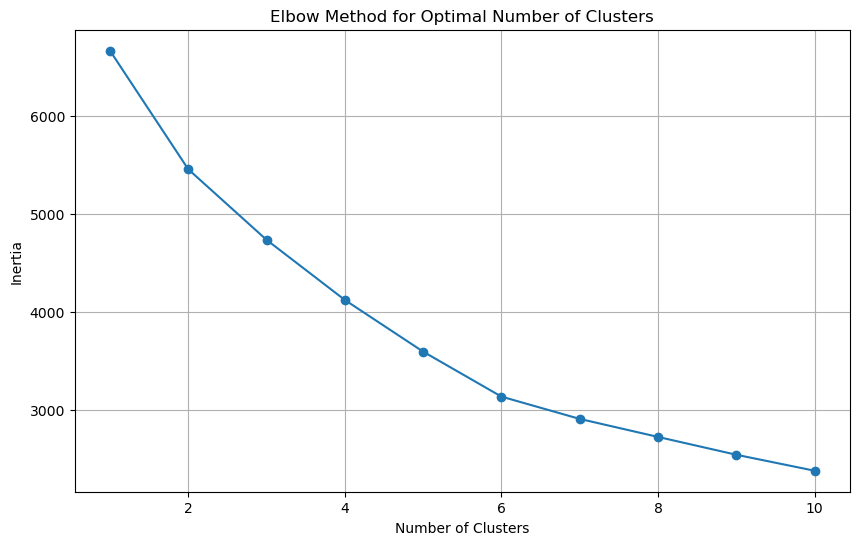

In [32]:
clustering_columns = ['CommuteTimePreCov', 'FoodTimePreCov', 
                      'percent_income_spent_on_housing', 'housing_problems', 'neighborhood_problems']

# Select and clean the data for clustering
clustering_data = df_all[clustering_columns].dropna()

mask = df_all[clustering_columns].notna().all(axis=1)
df_all = df_all[mask]

# Normalize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data)

# Determine the optimal number of clusters using the Elbow Method
inertia = []
silhouette_scores = []
for n in range(1, 11):
    kmeans = KMeans(n_clusters=n, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [33]:
# Choose the number of clusters based on the Elbow Method plot
optimal_clusters = 4  # Replace with your chosen number of clusters

# Fit KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=12)
df_all['cluster'] = kmeans.fit_predict(scaled_data)

<Figure size 1000x600 with 0 Axes>

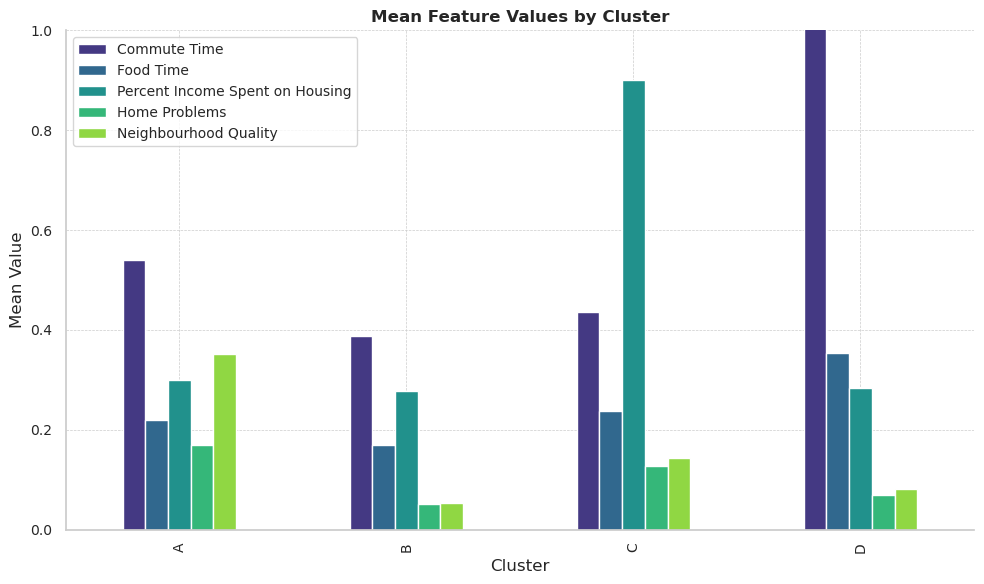

In [34]:
# Calculate the average eigenvalue for each cluster
cluster_means = df_all.groupby('cluster')[clustering_columns].mean()

# Define feature name mapping dictionary
new_labels = {
    'CommuteTimePreCov': 'Commute Time',
    'FoodTimePreCov': 'Food Time',
    'percent_income_spent_on_housing': 'Percent Income Spent on Housing',
    'housing_problems': 'Home Problems',
    'neighborhood_problems': 'Neighbourhood Quality'
}
cluster_means.rename(columns=new_labels, inplace=True)

# Mapping the cluster numbers to letters A, B, C, D
cluster_means.index = ['A', 'B', 'C', 'D']

sns.set(style="whitegrid")
colors = sns.color_palette("viridis", len(clustering_columns))

# Create a graph
plt.figure(figsize=(10, 6)) 
ax = cluster_means.plot(kind='bar', figsize=(10, 6), color=colors)

plt.title('Mean Feature Values by Cluster', fontsize=12, weight='bold')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Mean Value', fontsize=12)
plt.legend( title_fontsize='10', fontsize='10', loc='upper left')
plt.xticks(fontsize=10, rotation=90)  # Rotating labels to be vertical
plt.yticks(fontsize=10)
plt.ylim(0, 1)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
sns.despine()

plt.tight_layout()
plt.show()

In [35]:
# Count the number of observations in each cluster
cluster_sizes = df_all['cluster'].value_counts().sort_index()

# Convert to DataFrame for better readability
cluster_sizes_df = cluster_sizes.reset_index()
cluster_sizes_df.columns = ['cluster', 'Number_of_Observations']

# Display the cluster sizes
print(cluster_sizes_df)

   cluster  Number_of_Observations
0        0                     226
1        1                     676
2        2                     188
3        3                     242


In [36]:
print(len(df_all))

1332


### Linking Socioeconomic Attributes

In [37]:
# Demographic Attributes             
categorical_vars = [
    'Cur_Sex',
    'Cur_AgeCat', 
    'Cur_HHType',
]

# Create an empty DataFrame to store results
results = pd.DataFrame()

# Calculate percentages for each variable
for var in categorical_vars:
    # Calculate percentages
    percentages = df_all.groupby(['cluster', var]).size().unstack(fill_value=0)
    percentages = percentages.div(percentages.sum(axis=1), axis=0) * 100
    percentages = percentages.round(2)
    percentages = percentages.reset_index()
    percentages.columns.name = None
    percentages = percentages.rename_axis(None, axis=1)
    
    # Replace cluster numbers with letters
    percentages['cluster'] = percentages['cluster'].replace({0: 'A', 1: 'B', 2: 'C', 3: 'D'})

    # Merge with the existing results DataFrame
    if results.empty:
        results = percentages
    else:
        results = pd.merge(results, percentages, on='cluster', how='outer')

# Only format numerical columns
format_dict = {col: "{:.2f}" for col in results.columns if col != 'cluster'}

# Display results with Pandas styling and adjust column width
styled_results = results.style.format(format_dict) \
    .background_gradient(cmap='YlGnBu') \
    .set_table_styles([
        {'selector': 'th:not(:first-child), td:not(:first-child)', 'props': [('min-width', '40px')]},
        {'selector': 'td, th', 'props': [('max-width', '97px'), ('text-align', 'center')]}
    ])

# Display styled DataFrame
display(styled_results)

,cluster,Female,Male,18-29,30-39,40-49,50-59,60-69,70+,2 adults (no children),2 adults (with children),3+ adults (no children),3+ adults (with children),One adult (with children),Single person household
0,A,60.44,39.56,18.67,24.89,20.00,25.33,9.33,1.78,31.39,24.22,14.80,7.17,4.93,17.49
1,B,58.28,41.72,12.57,19.97,24.56,24.56,16.42,1.92,29.97,28.19,15.13,6.97,3.41,16.32
2,C,75.53,24.47,19.79,31.02,22.46,20.32,4.81,1.60,18.09,27.66,11.17,7.45,18.09,17.55
3,D,53.72,46.28,11.57,20.25,18.60,28.51,16.94,4.13,40.00,19.58,11.67,4.17,4.58,20.00


In [38]:
# Economic Attributes  
categorical_vars = [
  'Cur_HHIncomeEquiv4_21_Imputed',
  'Cur_HEdQual',
  'Cur_RClassGp'
]

# Define the boundaries and order of each categorical variable
income_order = ['£1000 or less', '£1001 to £1500', '£1501 to £2500', 'More than £2500']
occupation_order = [
    'Not classifiable',
    'Semi-routine & routine occupations',
    'Lower supervisory & technical occupations',
    'Small employers & own account workers',
    'Intermediate occupations',
    'Managerial & professional occupations'
]
education_order = [
    'No or Other qualifications', 
    'Other qualifications below A levels or vocational level 3 or equivalent', 
    'A levels or vocational level 3 or equivalent and above, but below degree', 
    'Degree or equivalent, and above'
]

results = pd.DataFrame()

# Calculate the percentage for each variable
for var in categorical_vars:
    percentages = df_all.groupby(['cluster', var]).size().unstack(fill_value=0)
    percentages = percentages.div(percentages.sum(axis=1), axis=0) * 100
    percentages = percentages.round(2)
    percentages = percentages.reset_index()
    percentages.columns.name = None
    percentages = percentages.rename_axis(None, axis=1)

    # Replace cluster numbers with letters
    percentages['cluster'] = percentages['cluster'].replace({0: 'A', 1: 'B', 2: 'C', 3: 'D'})

    # Merge the "No Education" and "Other Education" columns
    if 'No qualifications' in percentages.columns and 'Other qualification' in percentages.columns:
        percentages['No or Other qualifications'] = percentages['No qualifications'] + percentages['Other qualification']
        percentages = percentages.drop(columns=['No qualifications', 'Other qualification'])

    # Rearrange column labels
    if var == 'Cur_HHIncomeEquiv4_21_Imputed':
        percentages = percentages[['cluster'] + income_order]
    elif var == 'Cur_RClassGp':
        percentages = percentages[['cluster'] + occupation_order]
    elif var == 'Cur_HEdQual':
        education_cols = [col for col in education_order if col in percentages.columns]
        percentages = percentages[['cluster'] + education_cols]

    if results.empty:
        results = percentages
    else:
        results = pd.merge(results, percentages, on='cluster', how='outer')

# Only format numerical columns
format_dict = {col: "{:.2f}" for col in results.columns if col != 'cluster'}

# Display results with Pandas styling and adjust column width
styled_results = results.style.format(format_dict) \
    .background_gradient(cmap='YlGnBu') \
    .set_table_styles([
        {'selector': 'th:not(:first-child), td:not(:first-child)', 'props': [('min-width', '40px')]},
        {'selector': 'td, th', 'props': [('max-width', '98px'), ('text-align', 'center')]}
    ])

# Display styled DataFrame
display(styled_results)

,cluster,£1000 or less,£1001 to £1500,£1501 to £2500,More than £2500,No or Other qualifications,Other qualifications below A levels or vocational level 3 or equivalent,"A levels or vocational level 3 or equivalent and above, but below degree","Degree or equivalent, and above",Not classifiable,Semi-routine & routine occupations,Lower supervisory & technical occupations,Small employers & own account workers,Intermediate occupations,Managerial & professional occupations
0,A,17.04,18.83,32.74,31.39,7.08,14.60,21.68,56.64,1.77,10.18,7.08,4.87,13.27,62.83
1,B,13.20,15.73,34.12,36.94,8.88,15.24,21.45,54.44,1.63,11.39,8.73,5.18,9.17,63.91
2,C,64.89,20.74,7.98,6.38,14.36,16.49,25.53,43.62,4.26,17.02,10.64,6.91,13.30,47.87
3,D,10.42,16.25,30.83,42.50,4.56,9.54,19.09,66.80,0.41,5.79,4.55,5.37,5.37,78.51


In [39]:
# Social Attributes
categorical_vars = [
    'CommuteModePreCov',
    'health_deprived'
]

# Define the speed order of vehicles (from slow to fast)
commute_mode_order = [
    'On foot',
    'Bicycle',
    'Motorcycle, scooter, or moped',
    'Bus, minibus, or coach',
    'Taxi',
    'Car or van',
    'Underground, metro, light rail, tram',
    'Train'
]
results = pd.DataFrame()

# Calculate the percentage for each variable
for var in categorical_vars:
    percentages = df_all.groupby(['cluster', var]).size().unstack(fill_value=0)
    percentages = percentages.div(percentages.sum(axis=1), axis=0) * 100
    percentages = percentages.round(2)
    percentages = percentages.reset_index()
    percentages.columns.name = None
    percentages = percentages.rename_axis(None, axis=1)
    
    # Replace cluster numbers with letters
    percentages['cluster'] = percentages['cluster'].replace({0: 'A', 1: 'B', 2: 'C', 3: 'D'})

    # Change health label
    if var == 'health_deprived':
        percentages = percentages.rename(columns={0: 'Healthy', 1: 'Unhealthy'})

    # Deletion and merging make the presentation more intuitive
    if 'Studied from home' in percentages.columns:
        percentages = percentages.drop(columns=['Studied from home'])
    if 'Other' in percentages.columns:
        percentages = percentages.drop(columns=['Other'])
    if 'Driving a car or van' in percentages.columns and 'Passenger in a car or van' in percentages.columns:
        percentages['Car or van'] = percentages['Driving a car or van'] + percentages['Passenger in a car or van']
        percentages = percentages.drop(columns=['Driving a car or van', 'Passenger in a car or van'])

    # Reorder columns
    if var == 'CommuteModePreCov':
        ordered_columns = ['cluster'] + [col for col in commute_mode_order if col in percentages.columns]
        percentages = percentages[ordered_columns]
        
    if results.empty:
        results = percentages
    else:
        results = pd.merge(results, percentages, on='cluster', how='outer')

# Only format numerical columns
format_dict = {col: "{:.2f}" for col in results.columns if col != 'cluster'}

# Display results with Pandas styling and adjust column width
styled_results = results.style.format(format_dict) \
    .background_gradient(cmap='YlGnBu') \
    .set_table_styles([
        {'selector': 'th:not(:first-child), td:not(:first-child)', 'props': [('min-width', '40px')]},
        {'selector': 'td, th', 'props': [('max-width', '110px'), ('text-align', 'center')]}
    ])

# Display styled DataFrame
display(styled_results)

,cluster,On foot,Bicycle,"Motorcycle, scooter, or moped","Bus, minibus, or coach",Taxi,Car or van,"Underground, metro, light rail, tram",Train,Healthy,Unhealthy
0,A,11.56,4.89,0.00,8.44,0.00,60.00,8.44,6.67,94.69,5.31
1,B,11.61,6.99,0.89,4.91,0.00,66.37,4.91,4.17,97.34,2.66
2,C,20.32,2.14,1.07,8.56,1.07,50.80,9.09,6.95,92.02,7.98
3,D,4.96,2.07,0.83,7.85,0.41,47.11,11.57,25.21,95.45,4.55


# 4. Define the deprivation Interval 

In [40]:
csv_loc = "P15644_20220301_cleaned.csv"

In [41]:
ori_df = pd.read_csv(csv_loc)

In [42]:
ori_df.isnull().sum()

panelid_2                           0
Panel_PSU                           0
Panel_Strata                        0
Jun21_WeightBoost                   0
Jun21_IntDate                       0
Jun21_IntMode                       0
ff_disact                           3
Cur_GOR                             0
cur_urbrurew                      154
cur_urbrurs                      2239
Cur_Sex                             1
Cur_RClassGp                        0
Cur_AgeCat                          3
Cur_HEdQual                         1
Cur_RelStat5                        2
Cur_HHSize5                         8
Cur_HHChild                        18
Cur_HHType                         15
Cur_SubjInc                         1
Cur_HHIncome4_21                  271
Cur_HHIncome4_21_Imputed            0
Cur_HHIncomeEquiv4_21             284
Cur_HHIncomeEquiv4_21_Imputed      15
Cur_IdentClass                     18
Cur_PartyID5                        5
Cur_Ethnic6                        31
Cur_IntUse3 

In [43]:
ori_df.shape

(2393, 55)

### Feature Selection

In [44]:
# Features and Goals
selected_features = ori_df.columns.tolist()[6:]
X = ori_df[selected_features]
X = X.drop('Health', axis=1)
X = X.fillna(0)
y = ori_df['Health'].fillna(0)

Feature importance(>0.03):
 ff_disact              0.045681
Cur_GOR                0.038702
MortCost               0.039157
FoodTimePreCov         0.036196
FoodTime               0.033199
HousingCost            0.047375
HousingCostToIncome    0.051608
NeighQualTotal         0.063583
dtype: float64
Feature importance(>0.02):
 ff_disact                0.045681
Cur_GOR                  0.038702
Cur_RClassGp             0.022851
Cur_AgeCat               0.027125
Cur_HEdQual              0.023138
Cur_HHSize5              0.020592
Cur_HHType               0.021788
Cur_SubjInc              0.029093
Cur_HHIncomeEquiv4_21    0.020546
Cur_PartyID5             0.025672
MortCost                 0.039157
CvBedRoom                0.025726
WorkTimePreCov           0.026682
CommuteTimePreCov        0.025907
FoodTimePreCov           0.036196
WorkTime                 0.025148
FoodTime                 0.033199
HousingCost              0.047375
HousingCostToIncome      0.051608
HomeProbTotal            0.

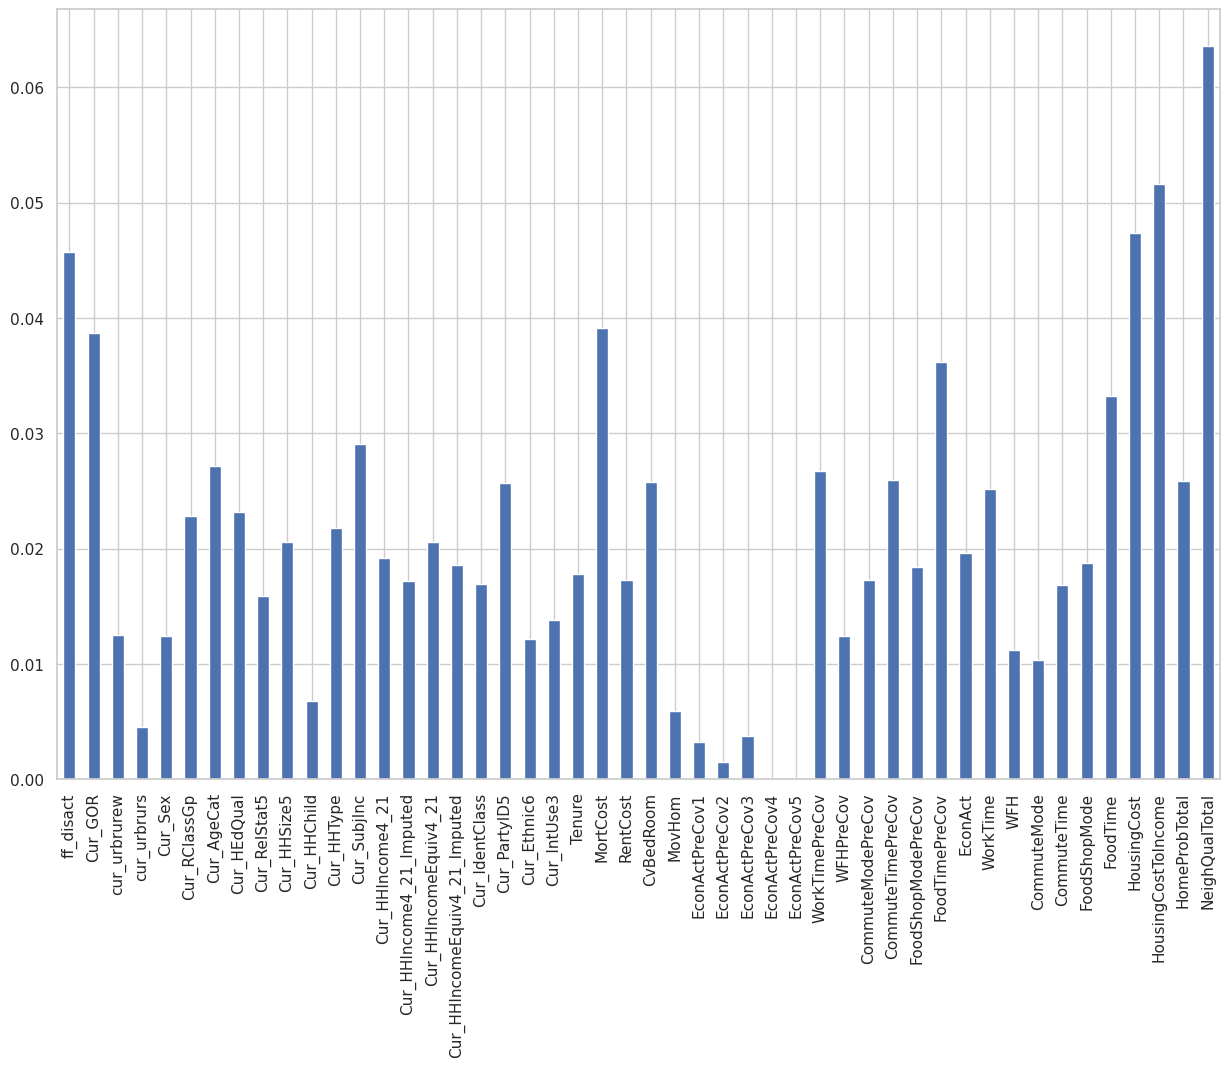

In [45]:
# Initialize the random forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Print feature importance
importances = model.feature_importances_
feature_importance = pd.Series(importances, index=X.columns)
filtered_features = feature_importance[feature_importance >= 0.03]
print("Feature importance(>0.03):\n", filtered_features)
filtered_features_2 = feature_importance[feature_importance >= 0.02]
print("Feature importance(>0.02):\n", filtered_features_2)

# Visualize feature importance
feature_importance.plot(figsize=(15,10), kind='bar')
plt.show()

### Data Transformation

In [46]:
ori_df = ori_df.dropna(subset=['HousingCostToIncome', 'HomeProbTotal', 'NeighQualTotal', 'CommuteTimePreCov', 'FoodTimePreCov'],
                      how='all')

#### Cut-off points

In [47]:
dep_stats = ori_df[['HousingCostToIncome', 'HomeProbTotal', 'NeighQualTotal', 
                'CommuteTimePreCov', 'FoodTimePreCov']].describe(percentiles=[0.25, 0.5, 0.75])

print(dep_stats)

       HousingCostToIncome  HomeProbTotal  NeighQualTotal  CommuteTimePreCov  \
count          2393.000000    2393.000000     2393.000000        1394.000000   
mean              0.304492       1.080234       27.012119          34.695122   
std               0.216922       1.536974        6.710031          30.939946   
min               0.000000       0.000000       12.000000           0.000000   
25%               0.142132       0.000000       23.000000          15.000000   
50%               0.260492       0.000000       26.000000          30.000000   
75%               0.406091       2.000000       31.000000          45.000000   
max               0.992908      11.000000       59.000000         360.000000   

       FoodTimePreCov  
count     2145.000000  
mean        14.099767  
std         11.922805  
min          1.000000  
25%          8.000000  
50%         10.000000  
75%         15.000000  
max        120.000000  


#### Housing Cost to Income

In [48]:
ori_df['HousingCostToIncomeGroup'] = pd.cut(ori_df['HousingCostToIncome'], bins=[0, 0.3, 0.4, 0.5, 1], 
                                            labels=[0,1,2,3])
ori_df['HousingCostToIncomeGroup'] = ori_df['HousingCostToIncomeGroup'].astype(float)
ori_df['HousingCostToIncomeGroup'] = ori_df['HousingCostToIncomeGroup'].fillna(0)
print(ori_df['HousingCostToIncomeGroup'].value_counts())

HousingCostToIncomeGroup
0.0    1373
3.0     415
1.0     339
2.0     266
Name: count, dtype: int64


#### HomeProbTotal

In [49]:
# Calculate the counts & percentage of each unique value in 'HomeProbTotal'
home_prob_total_counts = ori_df['HomeProbTotal'].value_counts()
home_prob_total_percentage = ori_df['HomeProbTotal'].value_counts(normalize=True) * 100

home_prob_total_summary = pd.DataFrame({
    'Count': home_prob_total_counts,
    'Percentage': home_prob_total_percentage
})

print(home_prob_total_summary)

               Count  Percentage
HomeProbTotal                   
0.0             1203   50.271626
1.0              528   22.064354
2.0              324   13.539490
3.0              150    6.268282
4.0               89    3.719181
5.0               42    1.755119
6.0               31    1.295445
7.0               12    0.501463
9.0                6    0.250731
8.0                6    0.250731
10.0               1    0.041789
11.0               1    0.041789


In [50]:
# Grouping
ori_df['HomeProbTotalGroup'] = pd.cut(ori_df['HomeProbTotal'], bins=[-1, 0, 2, 5, 14], labels=[0, 1, 2, 3])
ori_df['HomeProbTotalGroup'] = ori_df['HomeProbTotalGroup'].astype(float)
ori_df['HomeProbTotalGroup'] = ori_df['HomeProbTotalGroup'].fillna(0)
print(ori_df['HomeProbTotalGroup'].value_counts())

HomeProbTotalGroup
0.0    1203
1.0     852
2.0     281
3.0      57
Name: count, dtype: int64


#### NeighQualTotal

In [51]:
ori_df['NeighQualTotalGroup'] = pd.cut(ori_df['NeighQualTotal'], bins=[-1,24,30,36,60], labels=[0,1,2,3])
ori_df['NeighQualTotalGroup'] = ori_df['NeighQualTotalGroup'].astype(float)
ori_df['NeighQualTotalGroup'] = ori_df['NeighQualTotalGroup'].fillna(0)
print(ori_df['NeighQualTotalGroup'].value_counts())

NeighQualTotalGroup
0.0    883
1.0    845
2.0    460
3.0    205
Name: count, dtype: int64


#### Transport Time

In [52]:
# Eliminate data where both CommuteTimePreCov and FoodTimePreCov are null values
ori_df = ori_df.dropna(subset=['CommuteTimePreCov', 'FoodTimePreCov'], how='all')
ori_df['CommuteTimeGroup'] = pd.cut(ori_df['CommuteTimePreCov'], bins=[-1, 30, 40, 50, 120], labels=[0,1,2,3])
ori_df['FoodTimeGroup'] = pd.cut(ori_df['FoodTimePreCov'], bins=[-1, 5, 10, 15, 60], labels=[0,1,2,3])
    
# If CommuteTimeGroup is empty, the value of FoodTimeGroup is used
ori_df['TransportTimeGroup'] = ori_df['CommuteTimeGroup'].fillna(ori_df['FoodTimeGroup'])
ori_df['TransportTimeGroup'] = ori_df['TransportTimeGroup'].astype(float)
print(ori_df['TransportTimeGroup'].value_counts())

TransportTimeGroup
0.0    1042
3.0     447
1.0     411
2.0     368
Name: count, dtype: int64


In [53]:
ori_df['TransportTimeGroup'] = ori_df['TransportTimeGroup'].astype(float)
ori_df['TransportTimeGroup'] = ori_df['TransportTimeGroup'].fillna(0)
print(ori_df['TransportTimeGroup'].value_counts())

TransportTimeGroup
0.0    1054
3.0     447
1.0     411
2.0     368
Name: count, dtype: int64


#### Distribution after transformation

In [54]:
ori_df = ori_df.dropna(subset=['HousingCostToIncome', 'HomeProbTotal', 'NeighQualTotal', 'CommuteTimePreCov', 'FoodTimePreCov'],
                      how='all')

In [55]:
ori_df.shape

(2280, 61)

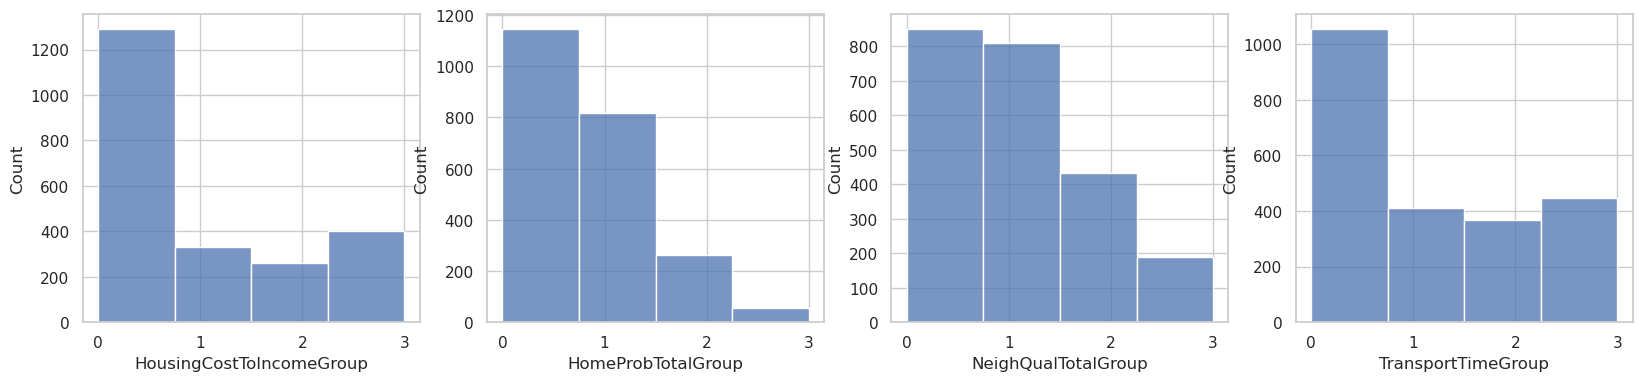

In [56]:
# plot for 'HousingCostToIncomeGroup'、'HomeProbTotalGroup' 、 'NeighQualTotalGroup' 、'TransportTimeGroup'
# plot in one figure
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
sns.histplot(ori_df['HousingCostToIncomeGroup'], ax=axes[0],bins=4)
axes[0].set_xticks(np.arange(0, 4, 1))
sns.histplot(ori_df['HomeProbTotalGroup'], ax=axes[1],bins=4)
axes[1].set_xticks(np.arange(0, 4, 1))
sns.histplot(ori_df['NeighQualTotalGroup'], ax=axes[2],bins=4)
axes[2].set_xticks(np.arange(0, 4, 1))
sns.histplot(ori_df['TransportTimeGroup'], ax=axes[3],bins=4)
axes[3].set_xticks(np.arange(0, 4, 1))
plt.show()

# 5. Descriptive statistics

In [57]:
df = ori_df.copy()

In [58]:
print(len(ori_df))

2280


### Box plots

<Axes: xlabel='TransportTimeGroup', ylabel='Health'>

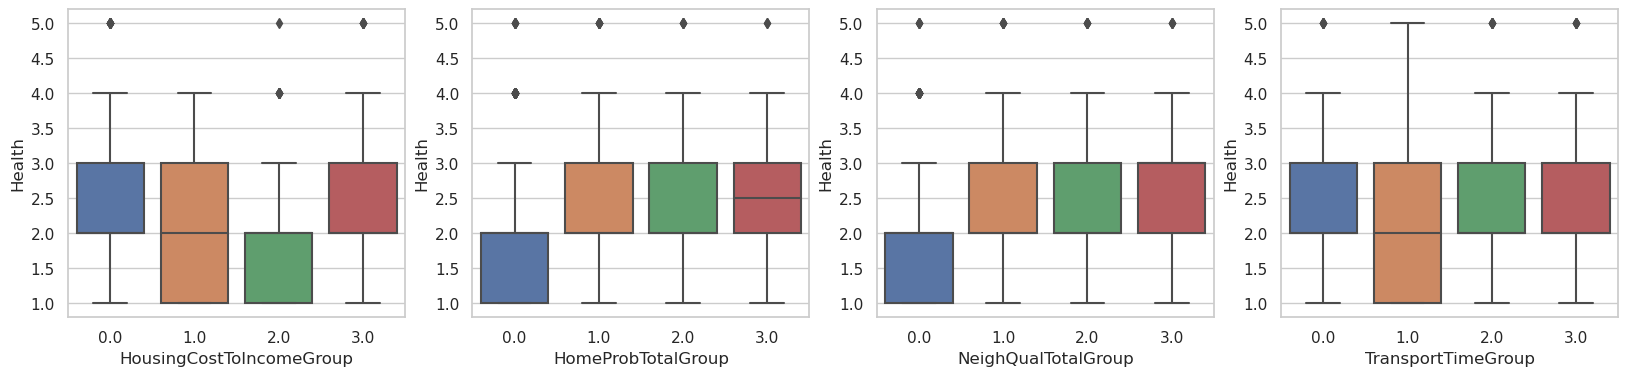

In [59]:
# plot boxplot for 'HousingCostToIncomeGroup'、'HomeProbTotalGroup' 、 'NeighQualTotalGroup' 、'TransportTimeGroup'
# plot in one figure
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
sns.boxplot(x='HousingCostToIncomeGroup', y='Health', data=df, ax=axes[0])
sns.boxplot(x='HomeProbTotalGroup', y='Health', data=df, ax=axes[1])
sns.boxplot(x='NeighQualTotalGroup', y='Health', data=df, ax=axes[2])
sns.boxplot(x='TransportTimeGroup', y='Health', data=df, ax=axes[3])

### Age, Income, Education and deprivations and Occupation and deprivations 

In [60]:
# Define the new column names once at the beginning
new_column_names = {
    'HousingCostToIncomeGroup': 'Housing Affordability Deprivation',
    'HomeProbTotalGroup': 'Home Problems Deprivation',
    'NeighQualTotalGroup': 'Neighbourhood Quality Deprivation',
    'TransportTimeGroup': 'Transport Time Deprivation'
}

# Viridis colormap setup
viridis = cm.get_cmap('viridis', 4)
colors = viridis.colors

# Age category analysis
age_labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70+']
original_columns = ['HousingCostToIncomeGroup', 'HomeProbTotalGroup', 'NeighQualTotalGroup', 'TransportTimeGroup']

results = {}
for col in original_columns:
    results[col] = df.groupby('Cur_AgeCat')[col].mean()

age_results = pd.DataFrame(results)
age_results.fillna(0, inplace=True)

# Calculate the percentage representation of each type of deprivation
age_results_percent = age_results.div(age_results.sum(axis=1), axis=0) * 100
age_results_percent = age_results_percent.div(age_results_percent.sum(axis=1), axis=0) * 100

age_results.rename(columns=new_column_names, inplace=True)

# Income category analysis
income_labels = ['£1000 or less', '£1001 to £1500', '£1501 to £2500', 'More than £2500']

results = {}
for col in original_columns:
    results[col] = df.groupby('Cur_HHIncomeEquiv4_21_Imputed')[col].mean()

income_results = pd.DataFrame(results)
income_results.fillna(0, inplace=True)
income_results.rename(columns=new_column_names, inplace=True)

# Educational level analysis
columns_to_analyze = original_columns

results = {}
for col in columns_to_analyze:
    results[col] = df.groupby('Cur_HEdQual')[col].mean()

edu_results = pd.DataFrame(results)
edu_results.rename(columns=new_column_names, inplace=True)
edu_results.index = range(1, 6)[::-1]

education_labels = {
    1: 'Degree and above',
    2: 'Below degree',
    3: 'A/vocational 3 and below',
    4: 'Other qualification',
    5: 'No qualifications'
}

# Occupation category analysis
results = {}
for col in columns_to_analyze:
    results[col] = df.groupby('Cur_RClassGp')[col].mean()

occupation_results = pd.DataFrame(results)
occupation_results.rename(columns=new_column_names, inplace=True)
occupation_results.index = range(1, 7)[::-1]

occupation_labels = {
    6: 'Managerial/Professional',
    5: 'Intermediate',
    4: 'Small Employers/Self-Employed',
    3: 'Lower Supervisory/Technical',
    2: 'Semi-routine/Routine',
    1: 'Not Classifiable'
}

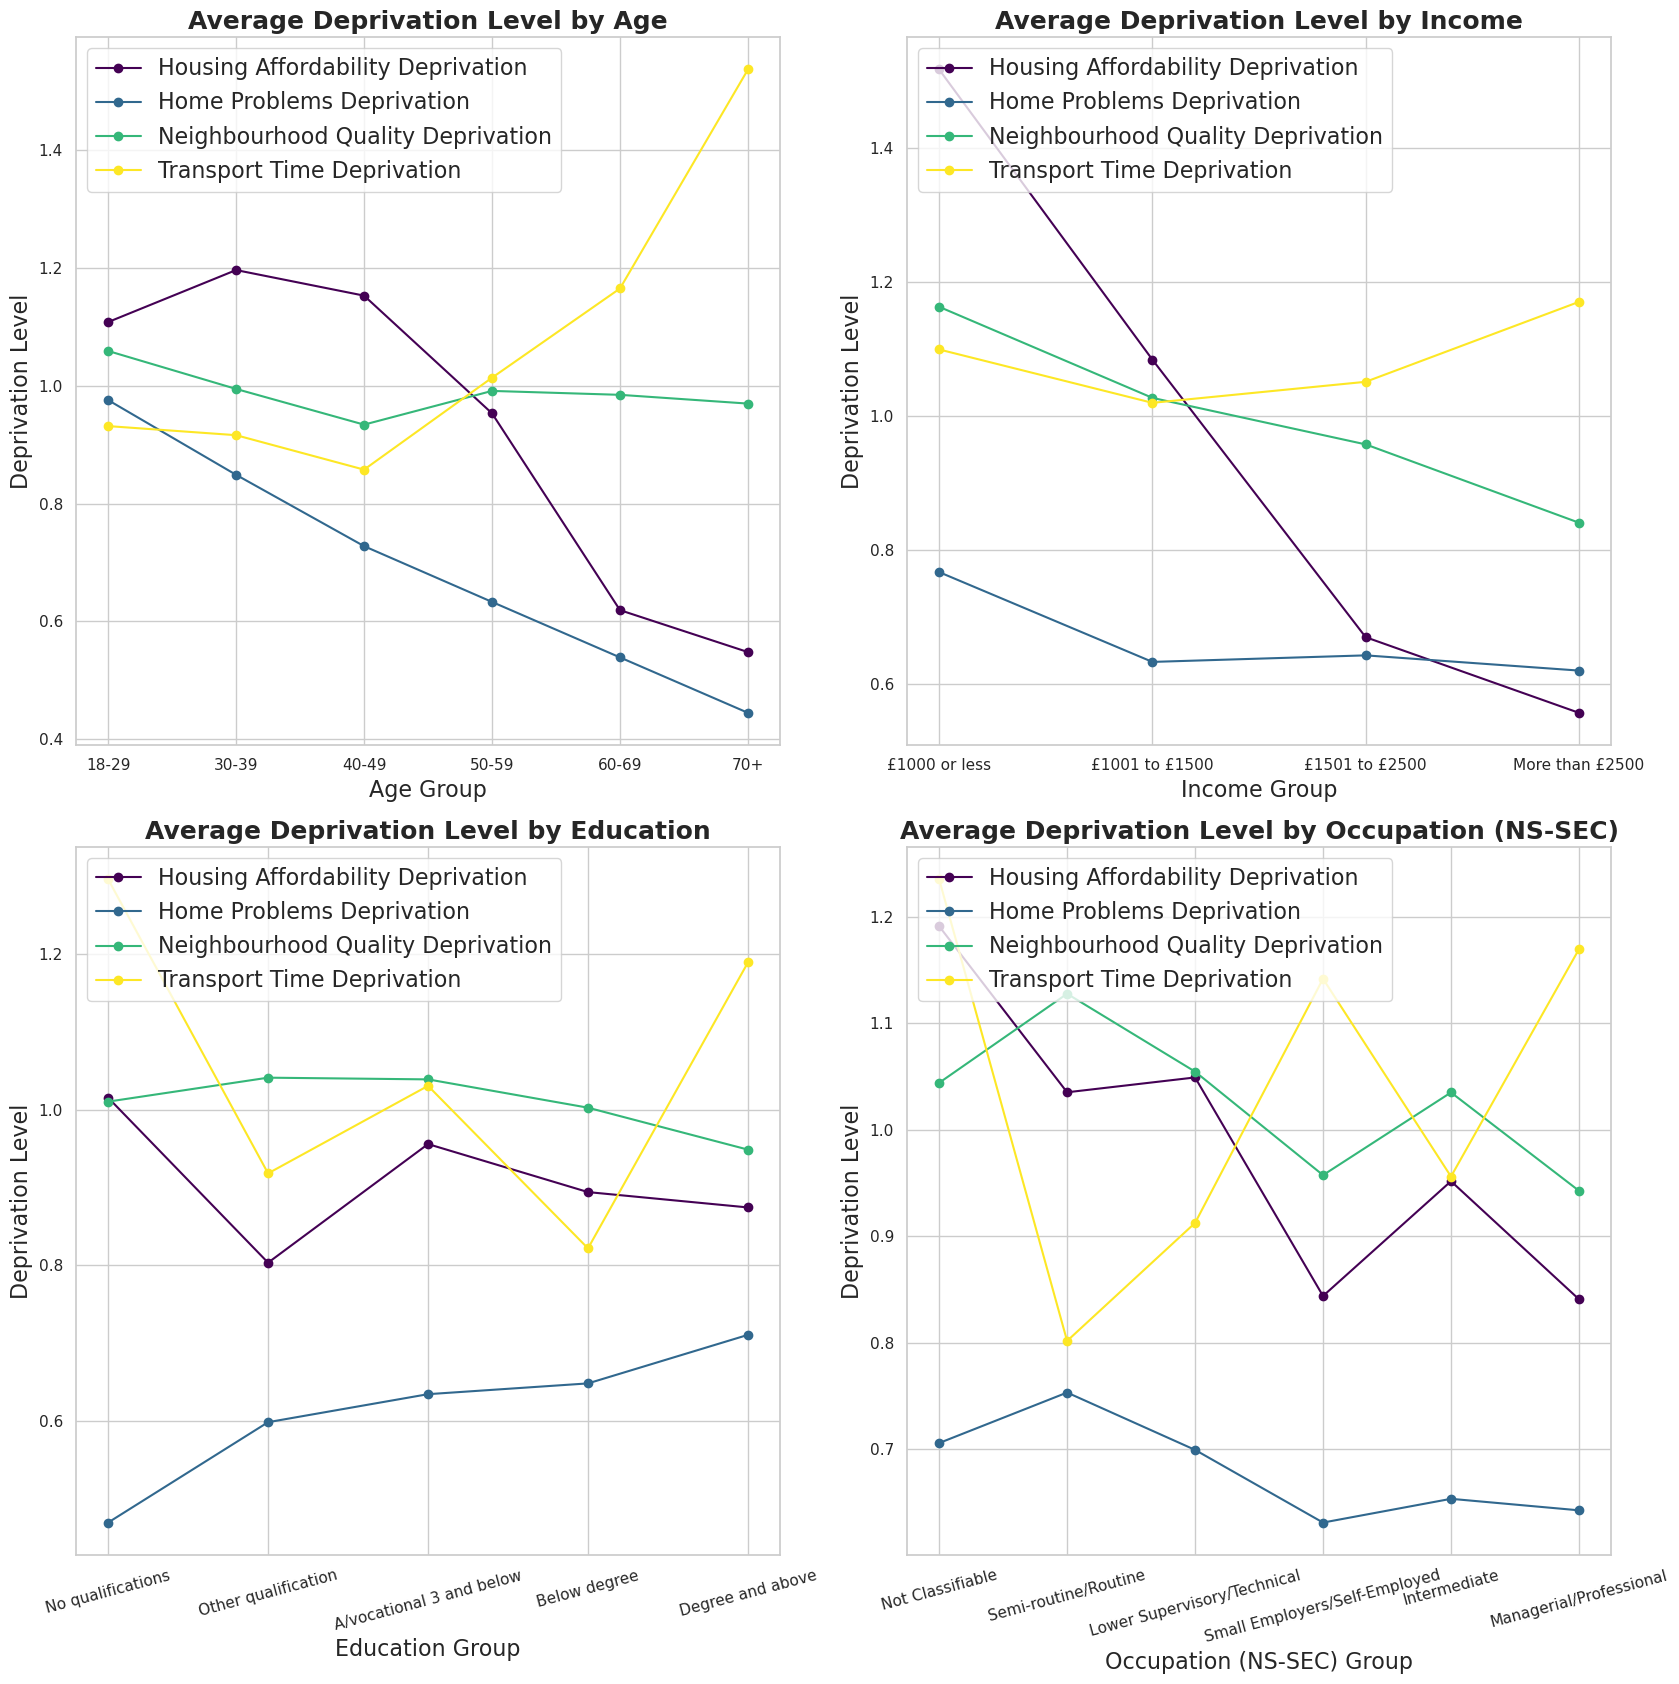

In [61]:
fig, axs = plt.subplots(2, 2, figsize=(17, 17))

# Set common parameters for font size and weight
title_fontsize = 18
title_fontweight = 'bold'
label_fontsize = 16
legend_fontsize = 16

for i, col in enumerate(age_results.columns):
    axs[0][0].plot(age_labels, age_results[col], label=col, marker='o', color=colors[i])
axs[0][0].set_title('Average Deprivation Level by Age', fontsize=title_fontsize, fontweight=title_fontweight)
axs[0][0].set_xlabel('Age Group', fontsize=label_fontsize)
axs[0][0].set_ylabel('Deprivation Level', fontsize=label_fontsize)
axs[0][0].legend(fontsize=legend_fontsize)

for i, col in enumerate(income_results.columns):
    axs[0][1].plot(income_labels, income_results[col], label=col, marker='o', color=colors[i])
axs[0][1].set_title('Average Deprivation Level by Income', fontsize=title_fontsize, fontweight=title_fontweight)
axs[0][1].set_xlabel('Income Group', fontsize=label_fontsize)
axs[0][1].set_ylabel('Deprivation Level', fontsize=label_fontsize)
axs[0][1].legend(loc='upper left', fontsize=legend_fontsize)

for col, color in zip(edu_results.columns, colors):
    axs[1][0].plot(edu_results.index, edu_results[col], label=col, marker='o', color=color)
axs[1][0].set_title('Average Deprivation Level by Education', fontsize=title_fontsize, fontweight=title_fontweight)
axs[1][0].set_xlabel('Education Group', fontsize=label_fontsize)
axs[1][0].set_ylabel('Deprivation Level', fontsize=label_fontsize)
axs[1][0].set_xticks(edu_results.index)
axs[1][0].set_xticklabels([education_labels[x] for x in sorted(education_labels.keys())], rotation=15)
axs[1][0].legend(loc='upper left', fontsize=legend_fontsize)

for col, color in zip(occupation_results.columns, colors):
    axs[1][1].plot(occupation_results.index, occupation_results[col], label=col, marker='o', color=color)
axs[1][1].set_title('Average Deprivation Level by Occupation (NS-SEC)', fontsize=title_fontsize, fontweight=title_fontweight)
axs[1][1].set_xlabel('Occupation (NS-SEC) Group', fontsize=label_fontsize)
axs[1][1].set_ylabel('Deprivation Level', fontsize=label_fontsize)
axs[1][1].set_xticks(range(1, len(occupation_results)+1))
axs[1][1].set_xticklabels([occupation_labels[x] for x in range(1, len(occupation_results)+1)], rotation=15)
axs[1][1].legend(loc='upper left', fontsize=legend_fontsize)

plt.tight_layout()
plt.show()

### Heat Map of Sample Size for Different Deprivation Combinations

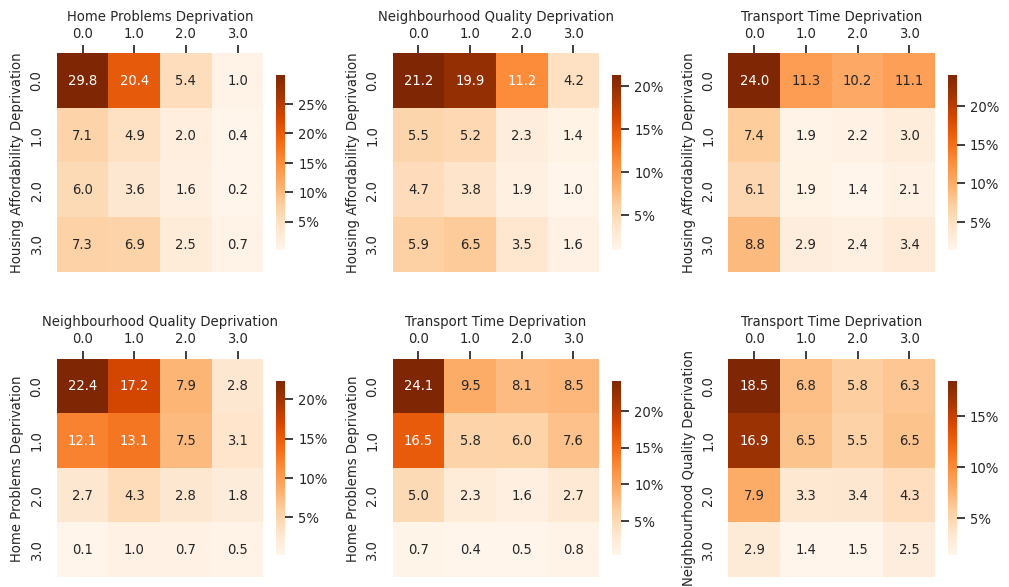

In [125]:
# Define the original list of column names
column_list = ['HousingCostToIncomeGroup', 'HomeProbTotalGroup', 'NeighQualTotalGroup', 'TransportTimeGroup']

# Create heat maps
fig, axes = plt.subplots(2, 3, figsize=(12, 6.8))

idx = 0
for i in range(4):
    for j in range(i + 1, 4):
        # Generate pivot tables
        pivot_table = df.pivot_table(index=column_list[i], columns=column_list[j], values='Health', aggfunc='count')
        percent_table = pivot_table / pivot_table.sum().sum() * 100
        
        # Heat mapping
        heatmap = sns.heatmap(percent_table, ax=axes[idx // 3, idx % 3], annot=True, fmt='.1f', cmap='Oranges', 
                              cbar_kws={'format': '%.0f%%', 'shrink': 0.8}, annot_kws={"size": 9.5})  
        axes[idx // 3, idx % 3].xaxis.tick_top()
        axes[idx // 3, idx % 3].xaxis.set_label_position('top')
        
        axes[idx // 3, idx % 3].set_xlabel(new_column_names[column_list[j]], fontsize=9.5)  
        axes[idx // 3, idx % 3].set_ylabel(new_column_names[column_list[i]], fontsize=9.5)  
        
        axes[idx // 3, idx % 3].tick_params(axis='both', which='major', labelsize=9.5)
        
        cbar = heatmap.collections[0].colorbar
        cbar.ax.yaxis.set_tick_params(labelsize=9.5)
        
        idx += 1
        
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

### Heat Map of Health Status under Different Deprivation Combinations

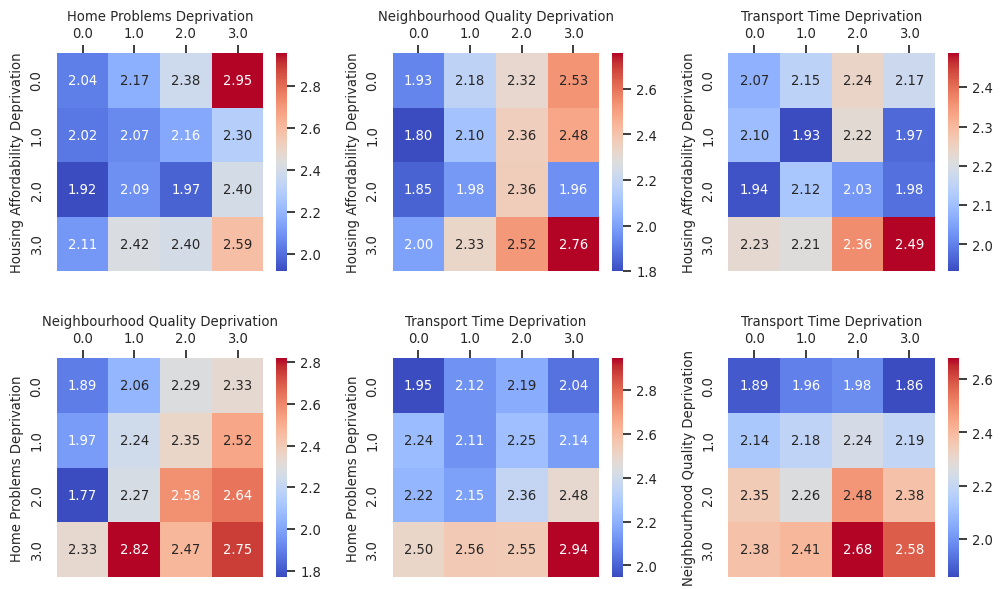

In [127]:
# Define the mapping for the column names
new_column_names = {
    'HousingCostToIncomeGroup': 'Housing Affordability Deprivation',
    'HomeProbTotalGroup': 'Home Problems Deprivation',
    'NeighQualTotalGroup': 'Neighbourhood Quality Deprivation',
    'TransportTimeGroup': 'Transport Time Deprivation'
}

# Define the original list of column names
column_list = ['HousingCostToIncomeGroup', 'HomeProbTotalGroup', 'NeighQualTotalGroup', 'TransportTimeGroup']

# Create heat maps
fig, axes = plt.subplots(2, 3, figsize=(12, 6.8))

# Each heatmap is drawn
sns.heatmap(df.pivot_table(index='HousingCostToIncomeGroup', columns='HomeProbTotalGroup', values='Health', aggfunc='mean'),
            ax=axes[0, 0], annot=True, fmt='.2f', cmap='coolwarm', annot_kws={"size": 9.5})
sns.heatmap(df.pivot_table(index='HousingCostToIncomeGroup', columns='NeighQualTotalGroup', values='Health', aggfunc='mean'),
            ax=axes[0, 1], annot=True, fmt='.2f', cmap='coolwarm', annot_kws={"size": 9.5})
sns.heatmap(df.pivot_table(index='HousingCostToIncomeGroup', columns='TransportTimeGroup', values='Health', aggfunc='mean'),
            ax=axes[0, 2], annot=True, fmt='.2f', cmap='coolwarm', annot_kws={"size": 9.5})
sns.heatmap(df.pivot_table(index='HomeProbTotalGroup', columns='NeighQualTotalGroup', values='Health', aggfunc='mean'),
            ax=axes[1, 0], annot=True, fmt='.2f', cmap='coolwarm', annot_kws={"size": 9.5})
sns.heatmap(df.pivot_table(index='HomeProbTotalGroup', columns='TransportTimeGroup', values='Health', aggfunc='mean'),
            ax=axes[1, 1], annot=True, fmt='.2f', cmap='coolwarm', annot_kws={"size": 9.5})
sns.heatmap(df.pivot_table(index='NeighQualTotalGroup', columns='TransportTimeGroup', values='Health', aggfunc='mean'),
            ax=axes[1, 2], annot=True, fmt='.2f', cmap='coolwarm', annot_kws={"size": 9.5})

# Set up labels and scales for each subplot
# Correctly set the labels using a specific mapping for each subplot
axes[0, 0].set_xlabel(new_column_names['HomeProbTotalGroup'], fontsize=9.5)
axes[0, 0].set_ylabel(new_column_names['HousingCostToIncomeGroup'], fontsize=9.5)

axes[0, 1].set_xlabel(new_column_names['NeighQualTotalGroup'], fontsize=9.5)
axes[0, 1].set_ylabel(new_column_names['HousingCostToIncomeGroup'], fontsize=9.5)

axes[0, 2].set_xlabel(new_column_names['TransportTimeGroup'], fontsize=9.5)
axes[0, 2].set_ylabel(new_column_names['HousingCostToIncomeGroup'], fontsize=9.5)

axes[1, 0].set_xlabel(new_column_names['NeighQualTotalGroup'], fontsize=9.5)
axes[1, 0].set_ylabel(new_column_names['HomeProbTotalGroup'], fontsize=9.5)

axes[1, 1].set_xlabel(new_column_names['TransportTimeGroup'], fontsize=9.5)
axes[1, 1].set_ylabel(new_column_names['HomeProbTotalGroup'], fontsize=9.5)

axes[1, 2].set_xlabel(new_column_names['TransportTimeGroup'], fontsize=9.5)
axes[1, 2].set_ylabel(new_column_names['NeighQualTotalGroup'], fontsize=9.5)

# Adjust the tick positions and label sizes
for i in range(2):
    for j in range(3):
        axes[i, j].xaxis.tick_top()
        axes[i, j].xaxis.set_label_position('top')
        axes[i, j].tick_params(axis='both', which='major', labelsize=9.5)

        # Adjust color bar font size
        cbar = axes[i, j].collections[0].colorbar
        cbar.ax.yaxis.set_tick_params(labelsize=9.5)

plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

### Co-correlation Matrix

In [64]:
# calculate the correlation matrix
global df
corr = df[['HousingCostToIncomeGroup', 'HomeProbTotalGroup', 'NeighQualTotalGroup', 'TransportTimeGroup', 'Health']].corr()
# rename the columns of corr
corr.columns = ['HousingCost.', 'HomeProb', 'NeighQual', 'TransportTime', 'Health']
corr.index = ['HousingCost.', 'HomeProb', 'NeighQual', 'TransportTime', 'Health']

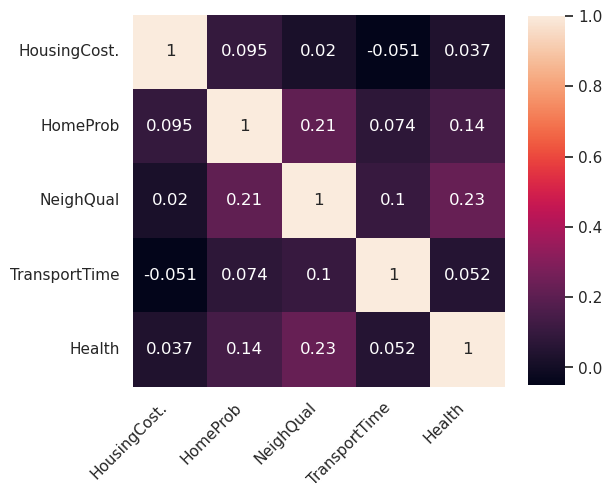

In [65]:
# plot map for correlation matrix
plt.figure(figsize=(6, 6))
ax = sns.heatmap(corr, annot=True, square=True, cbar_kws={'shrink': 0.8, 'aspect': 10})
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

In [66]:
# HousingCostToIncomeGroup & TransportTimeGroup
df['Housing&TransportGroup'] = df['HousingCostToIncomeGroup'] + df['TransportTimeGroup']
print(df['Housing&TransportGroup'].value_counts())

Housing&TransportGroup
0.0    547
3.0    546
1.0    426
2.0    415
4.0    165
5.0    103
6.0     78
Name: count, dtype: int64


### Convert Health to Binary

In [67]:
# Converting health into a binary classification
df['Health_bin'] = df['Health'].apply(lambda x: 0 if x in [1, 2] else 1)

In [68]:
df['Health_bin'] = pd.to_numeric(df['Health_bin'], errors='coerce')

In [69]:
df['Housing&TransportGroup'].value_counts()

Housing&TransportGroup
0.0    547
3.0    546
1.0    426
2.0    415
4.0    165
5.0    103
6.0     78
Name: count, dtype: int64

In [70]:
# Create dummy variables for the predictor
X_dummies = pd.get_dummies(df['Housing&TransportGroup'].astype(str),
                           drop_first=False, prefix='Housing&TransportGroup')

# Define the binary dependent variable
y = df['Health_bin']

# Create the binary logistic regression model
model = sm.Logit(y, X_dummies)

# Fit the model using the default method, which is 'newton' for sm.Logit
res = model.fit()

# Print the model's summary
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.603082
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:             Health_bin   No. Observations:                 2280
Model:                          Logit   Df Residuals:                     2273
Method:                           MLE   Df Model:                            6
Date:                Mon, 26 Aug 2024   Pseudo R-squ.:                0.007245
Time:                        23:53:07   Log-Likelihood:                -1375.0
converged:                       True   LL-Null:                       -1385.1
Covariance Type:            nonrobust   LLR p-value:                  0.002693
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Housing&TransportGroup_0.0    -1.1256      0.099    -11.322      0.000      

# 6. Binary Logit Model

In [71]:
df2 = df[['ff_disact', 'Cur_Sex', 'Cur_AgeCat', 'Cur_HEdQual', 'Cur_RClassGp',
          'HousingCostToIncomeGroup', 'HomeProbTotalGroup', 'NeighQualTotalGroup', 
          'TransportTimeGroup', 'Health_bin']]
df2 = df2.dropna(how='any')
df2.shape

(2273, 10)

In [72]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2273 entries, 0 to 2392
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ff_disact                 2273 non-null   float64
 1   Cur_Sex                   2273 non-null   float64
 2   Cur_AgeCat                2273 non-null   float64
 3   Cur_HEdQual               2273 non-null   float64
 4   Cur_RClassGp              2273 non-null   float64
 5   HousingCostToIncomeGroup  2273 non-null   float64
 6   HomeProbTotalGroup        2273 non-null   float64
 7   NeighQualTotalGroup       2273 non-null   float64
 8   TransportTimeGroup        2273 non-null   float64
 9   Health_bin                2273 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 195.3 KB


In [73]:
df2['Health_bin'].value_counts()

Health_bin
0    1599
1     674
Name: count, dtype: int64

In [74]:
df2.head(5)

,ff_disact,Cur_Sex,Cur_AgeCat,Cur_HEdQual,Cur_RClassGp,HousingCostToIncomeGroup,HomeProbTotalGroup,NeighQualTotalGroup,TransportTimeGroup,Health_bin
0,3.0,1.0,1.0,2.0,1.0,0.0,2.0,0.0,2.0,0
1,2.0,1.0,4.0,1.0,1.0,0.0,3.0,2.0,3.0,1
2,3.0,1.0,6.0,1.0,1.0,0.0,0.0,2.0,3.0,0
3,3.0,1.0,5.0,1.0,8.0,0.0,0.0,0.0,0.0,0
5,1.0,1.0,6.0,3.0,1.0,0.0,1.0,1.0,3.0,1


In [75]:
df2 = df2.astype(int)

In [76]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2273 entries, 0 to 2392
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   ff_disact                 2273 non-null   int64
 1   Cur_Sex                   2273 non-null   int64
 2   Cur_AgeCat                2273 non-null   int64
 3   Cur_HEdQual               2273 non-null   int64
 4   Cur_RClassGp              2273 non-null   int64
 5   HousingCostToIncomeGroup  2273 non-null   int64
 6   HomeProbTotalGroup        2273 non-null   int64
 7   NeighQualTotalGroup       2273 non-null   int64
 8   TransportTimeGroup        2273 non-null   int64
 9   Health_bin                2273 non-null   int64
dtypes: int64(10)
memory usage: 195.3 KB


### Single Independent Variables

In [77]:
def train_model(col, y_name, drop_first_v=False, para_type=1):
    ## col: the column names of the model
    ## y_name: Health or Health_bin
    if para_type == 1:
        # Create dummy variables for the column only
        X_dummies = pd.get_dummies(df2[['ff_disact','Cur_Sex', 'Cur_AgeCat', 'Cur_HEdQual', 'Cur_RClassGp', col]].astype(str), drop_first=drop_first_v)
    
        # Reset column names for X_dummies
        X_dummies.columns = [f"{name}" for name in X_dummies.columns]
    
    elif para_type == 2:
        X_dummies = pd.get_dummies(df2[['ff_disact','Cur_Sex', 'Cur_AgeCat', 'Cur_HEdQual', 'Cur_RClassGp',
                                        'HomeProbTotalGroup', 
                                        'NeighQualTotalGroup',
                                        'TransportTimeGroup']], drop_first=drop_first_v)
    elif para_type == 3:
        X_dummies = pd.get_dummies(df2[[ 'ff_disact','Cur_Sex', 'Cur_AgeCat', 'Cur_HEdQual', 'Cur_RClassGp',
                                        'HousingCostToIncomeGroup', 
                                        'HomeProbTotalGroup', 
                                        'NeighQualTotalGroup',
                                        'TransportTimeGroup']].astype(str), drop_first=drop_first_v)
    else:
        if len(col) == 2:
            X_dummies = pd.get_dummies(df2[['ff_disact','Cur_Sex', 'Cur_AgeCat', 'Cur_HEdQual', 'Cur_RClassGp',
                                            'HousingCostToIncomeGroup', 
                                            'HomeProbTotalGroup', 
                                            'NeighQualTotalGroup',
                                            'TransportTimeGroup']].astype(str), drop_first=drop_first_v)
            for i in range(4):
                for j in range(4):
                    if col[0] + f'_{i}' not in X_dummies.columns:
                        continue
                    if col[1] + f'_{j}' not in X_dummies.columns:
                        continue
                    X_dummies['_'.join(col) + f'_{i}_{j}'] = X_dummies[col[0] + f'_{i}'] * X_dummies[col[1] + f'_{j}']
        
        elif len(col) == 4:
            X_dummies = pd.get_dummies(df2[['ff_disact','Cur_Sex', 'Cur_AgeCat', 'Cur_HEdQual', 'Cur_RClassGp',
                                            'HousingCostToIncomeGroup', 
                                            'HomeProbTotalGroup', 
                                            'NeighQualTotalGroup',
                                            'TransportTimeGroup']].astype(str), drop_first=drop_first_v)
            for i in range(4):
                for j in range(4):
                    for k in range(4):
                        for l in range(4):
                            if col[0] + f'_{i}' not in X_dummies.columns:
                                continue
                            if col[1] + f'_{j}' not in X_dummies.columns:
                                continue
                            if col[2] + f'_{k}' not in X_dummies.columns:
                                continue
                            if col[3] + f'_{l}' not in X_dummies.columns:
                                continue
                            X_dummies['_'.join(col) + f'_{i}_{j}_{k}_{l}'] = X_dummies[col[0] + f'_{i}'] * X_dummies[col[1] + f'_{j}'] * \
                                                                             X_dummies[col[2] + f'_{k}'] * X_dummies[col[3] + f'_{l}']
             
    # Drop rows with missing values
    X_dummies = X_dummies.dropna()
    
    # Convert boolean to integer
    X_dummies = X_dummies.astype(float)
    
    # Ensure the constant is added
    X_dummies = sm.add_constant(X_dummies)
        
    # Define the binary dependent variable
    y = df2[y_name].loc[X_dummies.index]  # Ensure y is aligned with X_dummies

    # Create the binary logistic regression model
    model = sm.Logit(y, X_dummies)

    # Fit the model
    res = model.fit()

    # Print the model's summary
    return res

def get_R2(res):
    ## calculate the model R2
    llf = res.llf  
    llnull = res.llnull  
    aic = res.aic  
    bic = res.bic  
    
    # McFadden R²
    pseudo_r2 = 1 - (llf / llnull)
    
    print("AIC:", aic)
    print("BIC:", bic)
    print("McFadden's Pseudo R²:", pseudo_r2)
    print(f"\n\n")

In [78]:
selected_one = df2.columns[5:9]

In [79]:
selected_one

Index(['HousingCostToIncomeGroup', 'HomeProbTotalGroup', 'NeighQualTotalGroup',
       'TransportTimeGroup'],
      dtype='object')

In [80]:
df2[df2['HousingCostToIncomeGroup'] == 0]['Health_bin'].value_counts()

Health_bin
0    909
1    379
Name: count, dtype: int64

In [81]:
for col in selected_one:
    res = train_model(col, 'Health_bin', True, 1)
    print(f"The result of {col}:")
    print(res.summary())
    get_R2(res)

Optimization terminated successfully.
         Current function value: 0.505249
         Iterations 6
The result of HousingCostToIncomeGroup:
                           Logit Regression Results                           
Dep. Variable:             Health_bin   No. Observations:                 2273
Model:                          Logit   Df Residuals:                     2252
Method:                           MLE   Df Model:                           20
Date:                Mon, 26 Aug 2024   Pseudo R-squ.:                  0.1688
Time:                        23:53:07   Log-Likelihood:                -1148.4
converged:                       True   LL-Null:                       -1381.7
Covariance Type:            nonrobust   LLR p-value:                 2.790e-86
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -0.130

### Multiple Independent Variables

In [82]:
col = ['HousingCostToIncomeGroup', 'HomeProbTotalGroup', 'NeighQualTotalGroup', 'TransportTimeGroup']
y_name = 'Health_bin'

# Train Model
res = train_model(col, y_name, True, 3)
# Print model summary
print(res.summary())
get_R2(res)

Optimization terminated successfully.
         Current function value: 0.485985
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             Health_bin   No. Observations:                 2273
Model:                          Logit   Df Residuals:                     2243
Method:                           MLE   Df Model:                           29
Date:                Mon, 26 Aug 2024   Pseudo R-squ.:                  0.2005
Time:                        23:53:07   Log-Likelihood:                -1104.6
converged:                       True   LL-Null:                       -1381.7
Covariance Type:            nonrobust   LLR p-value:                 1.970e-98
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -1.0668      0.286     -3.724      0.000      

### Interaction Terms

In [83]:
selected_col = [
    ['HousingCostToIncomeGroup','HomeProbTotalGroup'],
    ['HousingCostToIncomeGroup','NeighQualTotalGroup'],
    ['HousingCostToIncomeGroup','TransportTimeGroup'],
    ['HomeProbTotalGroup','NeighQualTotalGroup'],
    ['HomeProbTotalGroup','TransportTimeGroup'],
    ['NeighQualTotalGroup','TransportTimeGroup']
]

In [84]:
for col in selected_col:
    res = train_model(col, 'Health_bin', True, 4)
    print(res.summary())
    get_R2(res)

Optimization terminated successfully.
         Current function value: 0.485154
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             Health_bin   No. Observations:                 2273
Model:                          Logit   Df Residuals:                     2234
Method:                           MLE   Df Model:                           38
Date:                Mon, 26 Aug 2024   Pseudo R-squ.:                  0.2019
Time:                        23:53:07   Log-Likelihood:                -1102.8
converged:                       True   LL-Null:                       -1381.7
Covariance Type:            nonrobust   LLR p-value:                 1.211e-93
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
const                             